# Tespa Info and Statistics (Spring 2019 National League)

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string, re, time
from pprint import pprint
from urllib.request import urlopen
from urllib.parse import quote    
from scrapy.crawler import CrawlerProcess, CrawlerRunner
import datetime
from scrapy import Request
from scrapy.spiders import Spider
from twisted.internet import reactor, defer


# Set default plot size so graphs will be more readable
plt.rcParams['figure.figsize'] = [9, 7]

In [3]:
# Scrape data
TOURNAMENT_URL = 'https://compete.tespa.org/tournament/124'
leaderboard_path = './tespa_leaderboard.csv'
teams_path = './tespa_teams.csv'


In [ ]:
def normalize_leaderboard():
    df_leaderboard = pd.read_csv(leaderboard_path) 
    df_leaderboard['team_name'] = df_leaderboard['team_name'].apply(lambda x: x[x.find('] ') + 2:])
    df_leaderboard.to_csv(leaderboard_path)

class CollectLeaderboard(Spider):
    name = 's2'

    #allowed_domains
    name = "s2"
    allowed_domains = ["tespa.org"]
    start_urls = [TOURNAMENT_URL + "/leaderboard"]
    custom_settings = {
            'DOWNLOAD_DELAY': 0.1,
            'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)',
            'FEED_FORMAT': 'csv',
            'FEED_URI': leaderboard_path
           }

    def parse(self, response):
        names = response.xpath("//table/tbody/tr")
        ans=[]
        for name in names:
            #print (name)
            item = {}
            item['rank'] = name.xpath('td[1]/text()').extract()
            item['team_name'] = name.xpath("td/a/span/text()").extract()
            item['rating'] = name.xpath("td[3]/text()").extract()
            item['timestamp'] = datetime.datetime.now()
            ans.append(item)
        return ans


class CollectTeams(Spider):
    name = 's2'

    #allowed_domains
    name = "s2"
    allowed_domains = ["tespa.org"]
    start_urls = [TOURNAMENT_URL + "/registrants?page={}".format(i) for i in range(1,24)]
    custom_settings = {
            'DOWNLOAD_DELAY': 0.1,
            'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)',
            'FEED_FORMAT': 'csv',
            'FEED_URI': teams_path
           }

    def parse(self, response):
        names = response.xpath('//table/tbody/tr')
        ans=[]
        for name in names:
            item = {}
            item['team_name'] = name.xpath('td/a/text()').extract()
            item['team_school'] = name.xpath("td[4]/text()").extract()
            item['team_link_url'] = name.xpath("td/a/@href").extract()
            item['team_rank'] = name.xpath("td[@class='registrant-ranks']/text()").extract()
            if item['team_link_url']:
                req = Request((str(item['team_link_url'][0])), callback=self.parse_2)
                req.meta['foo'] = item
                ans.append(req)
        return ans

    def parse_2(self, response):
        it = response.meta['foo']
        btag = response.xpath('//div/table/tbody/tr/td[3]/text()').extract()
        it['btag'] = btag
        return it           
    
runner = CrawlerRunner()
runner.crawl(CollectLeaderboard)
runner.crawl(CollectTeams)
d = runner.join()
d.addBoth(lambda _: reactor.stop())
reactor.run(0)

In [4]:
# Load scraped data 
df_raw = pd.read_csv(teams_path) 
df_raw['btag'] = df_raw['btag'].str.split(',')

#df_leaderboard = pd.read_csv('tespa_leaderboard_w1.csv')
df_leaderboard = pd.read_csv(leaderboard_path)

# Preliminary exploration... 
df_raw['member_count'] = df_raw.btag.str.len()
df_raw.groupby('member_count').count()['btag']


member_count
1       1
3       2
4       2
5      10
6     122
7     238
8     308
9     324
10     56
Name: btag, dtype: int64

Somehow, one team has 11 members (max allowed is 9+1 community manager). A concurrency problem when inserting into the Tespa database, or a special exception?

**Edit:** The team with 11 members removed their extra member after tespa staff was notified of the problem.

In [5]:
# Wait, what?
df_10 = df_raw.query('member_count == 11')
df_10

,team_name,team_school,team_link_url,team_rank,btag,member_count


In [6]:
df_valid = df_raw.query('member_count > 5')

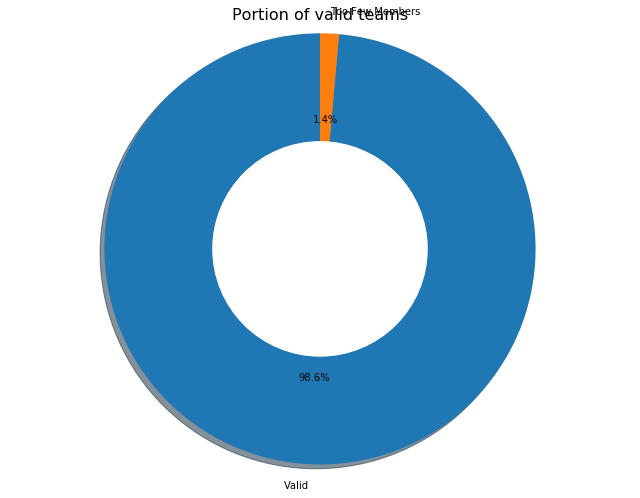

In [7]:
labels = ['Valid', 'Too Few Members']
sizes = [len(df_valid), len(df_raw) - len(df_valid)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)

# Plot
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
fig.suptitle('Portion of valid teams', fontsize=16)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

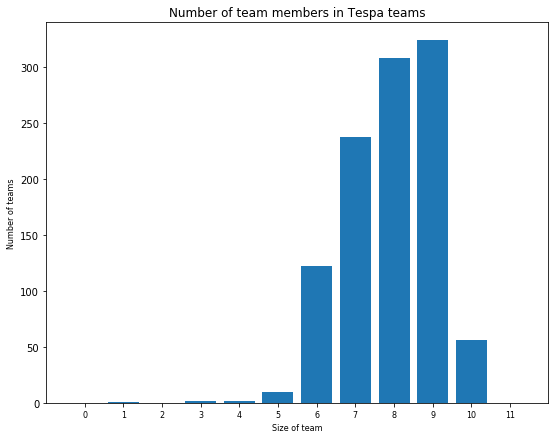

In [8]:
labels_count = list(range(12))
sizes_count = [len(df_raw.query('member_count == {}'.format(i)).index) for i in labels_count]
fig1, ax1 = plt.subplots()

index = np.arange(len(labels_count))
plt.bar(labels_count, sizes_count)
plt.xlabel('Size of team', fontsize=8)
plt.ylabel('Number of teams', fontsize=8)
plt.xticks(index, labels_count, fontsize=8)
plt.title('Number of team members in Tespa teams')
plt.show()

In [9]:
# Unpack lists of team members into rows
s = df_valid.apply(lambda x: pd.Series(x['btag']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'btag'
df_btags = df_valid.drop('btag', axis=1).join(s).reset_index(drop=True)
df_btags = df_btags[['btag', 'team_name']]
df_btags.head()

Now for the fun stuff, scraping player profiles for each btag collected. Takes about an hour using the default request delay of 0.2s plus processing time.

In [15]:
count = 0

def parse_re_int(reg, rawhtml):
    matchObj = re.search(reg ,rawhtml)
    if matchObj == None: 
        return None
    else:
        return int(matchObj.group(1))
    
def parse_re_str(reg, rawhtml):
    matchObj = re.search(reg ,rawhtml)
    if matchObj == None: 
        return None
    else:
        return str(matchObj.group(1))

def get_stats(btag):
    global count
    if count % 5 == 0:
        print("Parsed btags:", count)
    re_sr = r'u-align-center h5">(\d{3,4})<'
    re_comp_main = r'data-hero-competitive="(\w{1,})"'
    re_qp_main = r'data-hero-quickplay="(\w{1,})"'
    
    url_prefix = 'https://playoverwatch.com/en-us/career/pc/'
    url = url_prefix + quote(btag)
    try:
        rawhtml = urlopen(url).read().decode('utf-8')
    except:
        return ["Scrape fault"] * 3
    time.sleep(0.2) # add delay between requests
    count += 1 # progress indication
    
    return [parse_re_int(re_sr, rawhtml), parse_re_str(re_comp_main, rawhtml), parse_re_str(re_qp_main, rawhtml)]


In [ ]:
# Use this to test if what is being scraped is what you expect
'''
df_sample = df_btags.sample(25)
df_sample[['SR', 'Comp_main', 'QP_main']] = df_sample.apply(lambda row: pd.Series(get_stats(row['btag'].replace('#','-'))),axis=1)
df_sample
'''
# Takes a long time to scrape all 3.2k players
df_btags[['SR', 'Comp_main', 'QP_main']] = df_btags.apply(lambda row: pd.Series(get_stats(row['btag'].replace('#','-'))),axis=1)
df_btags

# Load previous scrape
# df_btags = pd.read_csv('btags.csv')


Parsed btags: 0
Parsed btags: 5
Parsed btags: 10
Parsed btags: 15
Parsed btags: 20
Parsed btags: 25
Parsed btags: 30
Parsed btags: 35
Parsed btags: 40
Parsed btags: 45
Parsed btags: 50
Parsed btags: 55
Parsed btags: 60
Parsed btags: 65
Parsed btags: 70
Parsed btags: 75
Parsed btags: 80
Parsed btags: 85
Parsed btags: 90
Parsed btags: 95
Parsed btags: 100
Parsed btags: 105
Parsed btags: 110
Parsed btags: 115
Parsed btags: 120
Parsed btags: 125
Parsed btags: 130
Parsed btags: 135
Parsed btags: 140
Parsed btags: 145
Parsed btags: 150
Parsed btags: 155
Parsed btags: 160
Parsed btags: 165
Parsed btags: 170
Parsed btags: 175
Parsed btags: 180
Parsed btags: 185
Parsed btags: 190
Parsed btags: 195
Parsed btags: 200
Parsed btags: 205
Parsed btags: 210
Parsed btags: 215
Parsed btags: 220
Parsed btags: 225
Parsed btags: 230
Parsed btags: 235
Parsed btags: 240
Parsed btags: 245
Parsed btags: 250
Parsed btags: 255
Parsed btags: 260
Parsed btags: 265
Parsed btags: 270
Parsed btags: 275
Parsed btags: 

Parsed btags: 2215
Parsed btags: 2220
Parsed btags: 2225
Parsed btags: 2230
Parsed btags: 2235
Parsed btags: 2240
Parsed btags: 2245
Parsed btags: 2250
Parsed btags: 2255
Parsed btags: 2260
Parsed btags: 2265
Parsed btags: 2270
Parsed btags: 2275
Parsed btags: 2280
Parsed btags: 2285
Parsed btags: 2290
Parsed btags: 2295
Parsed btags: 2300
Parsed btags: 2305
Parsed btags: 2310
Parsed btags: 2315
Parsed btags: 2320
Parsed btags: 2325
Parsed btags: 2330
Parsed btags: 2335
Parsed btags: 2340
Parsed btags: 2345
Parsed btags: 2350
Parsed btags: 2355
Parsed btags: 2360
Parsed btags: 2365
Parsed btags: 2370
Parsed btags: 2375
Parsed btags: 2380
Parsed btags: 2385
Parsed btags: 2390
Parsed btags: 2395
Parsed btags: 2400
Parsed btags: 2405
Parsed btags: 2410
Parsed btags: 2415
Parsed btags: 2420
Parsed btags: 2425
Parsed btags: 2430
Parsed btags: 2435
Parsed btags: 2440
Parsed btags: 2445
Parsed btags: 2450
Parsed btags: 2455
Parsed btags: 2460
Parsed btags: 2465
Parsed btags: 2470
Parsed btags

Parsed btags: 4375
Parsed btags: 4380
Parsed btags: 4385
Parsed btags: 4390
Parsed btags: 4395
Parsed btags: 4400
Parsed btags: 4405
Parsed btags: 4410
Parsed btags: 4415
Parsed btags: 4420
Parsed btags: 4425
Parsed btags: 4430
Parsed btags: 4435
Parsed btags: 4440
Parsed btags: 4445
Parsed btags: 4450
Parsed btags: 4455
Parsed btags: 4460
Parsed btags: 4465
Parsed btags: 4470
Parsed btags: 4475
Parsed btags: 4480
Parsed btags: 4485
Parsed btags: 4490
Parsed btags: 4495
Parsed btags: 4500
Parsed btags: 4505
Parsed btags: 4510
Parsed btags: 4515
Parsed btags: 4520
Parsed btags: 4525
Parsed btags: 4530
Parsed btags: 4535
Parsed btags: 4540
Parsed btags: 4545
Parsed btags: 4550
Parsed btags: 4555
Parsed btags: 4560
Parsed btags: 4565
Parsed btags: 4570
Parsed btags: 4575
Parsed btags: 4580
Parsed btags: 4585
Parsed btags: 4590
Parsed btags: 4595
Parsed btags: 4600
Parsed btags: 4605
Parsed btags: 4610
Parsed btags: 4615
Parsed btags: 4620
Parsed btags: 4625
Parsed btags: 4630
Parsed btags

In [ ]:
# Add a categorical rank based on SR
bins = [0, 1500, 2000, 2500, 3000, 3500, 4000, 4250, 4500, 4750, 5000]
labels = ['bronze','silver','gold','plat','diamond','masters','gm','semipro','pro','god']
df_btags['rank'] = pd.cut(df_btags['SR'], bins=bins, labels=labels)
df_btags['rank']

# Make sure to save our scrape!
df_btags.to_csv('btags.csv')

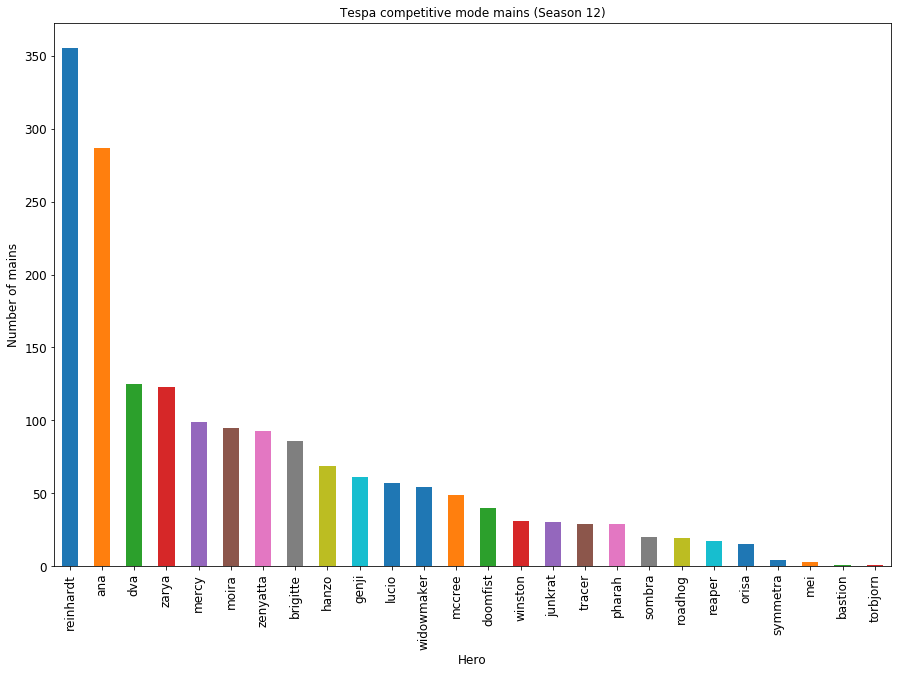

In [11]:
ax = pd.value_counts(df_btags['Comp_main']).plot(kind='bar', title ="Tespa competitive mode mains (Season 12)", figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("Hero", fontsize=12)
ax.set_ylabel("Number of mains", fontsize=12)
plt.show()

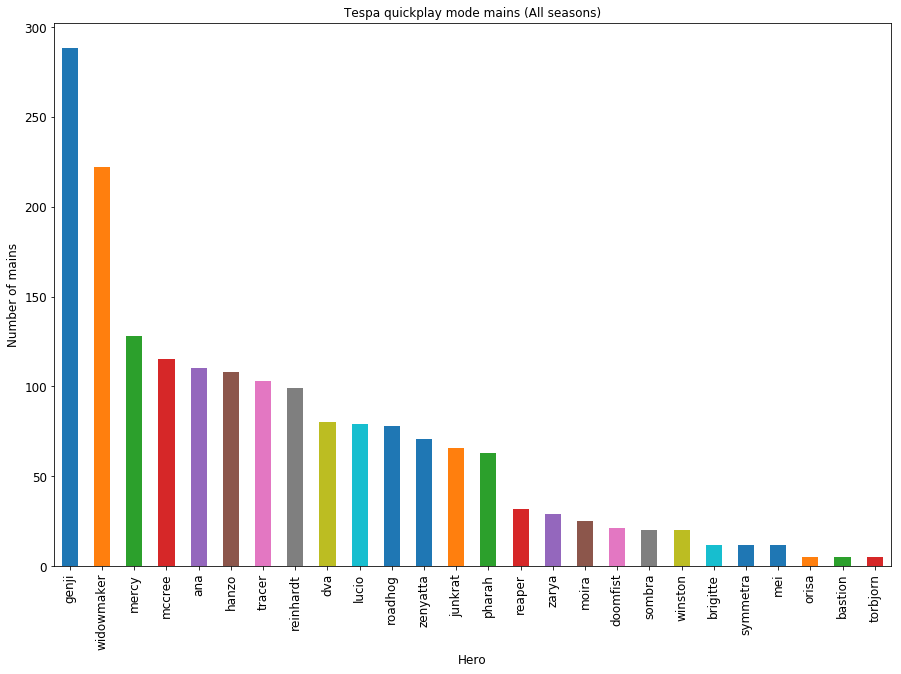

In [12]:
ax = pd.value_counts(df_btags['QP_main']).plot(kind='bar', title ="Tespa quickplay mode mains (All seasons)", figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("Hero", fontsize=12)
ax.set_ylabel("Number of mains", fontsize=12)
plt.show()

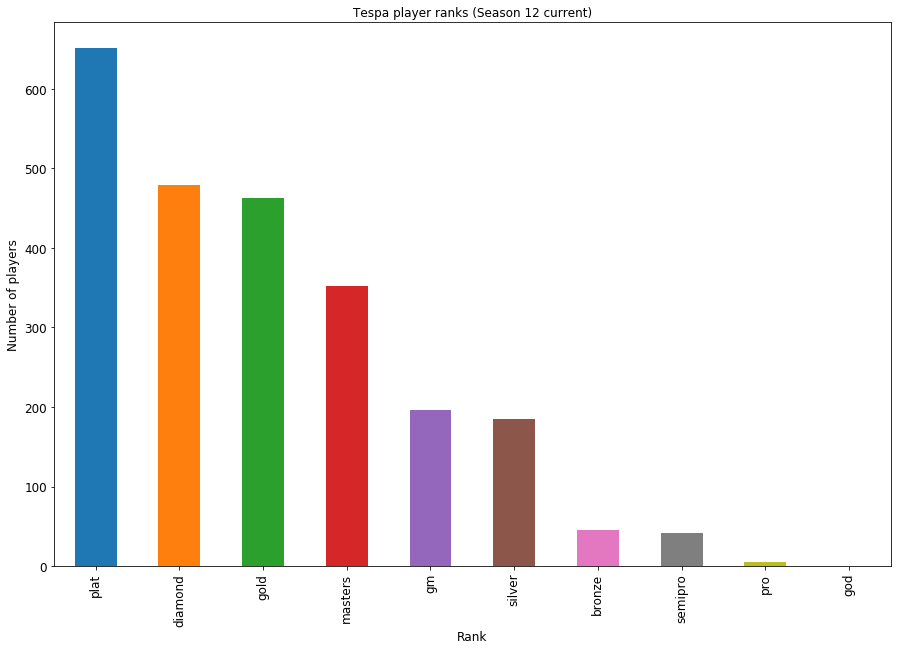

In [13]:
ax = pd.value_counts(df_btags['rank']).plot(kind='bar', title ="Tespa player ranks (Season 12 current)", figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("Rank", fontsize=12)
ax.set_ylabel("Number of players", fontsize=12)
plt.show()

**Note**: gm = 4000-4250, semipro = 4250-4500, pro = 4500-4750, god = 4750-5000

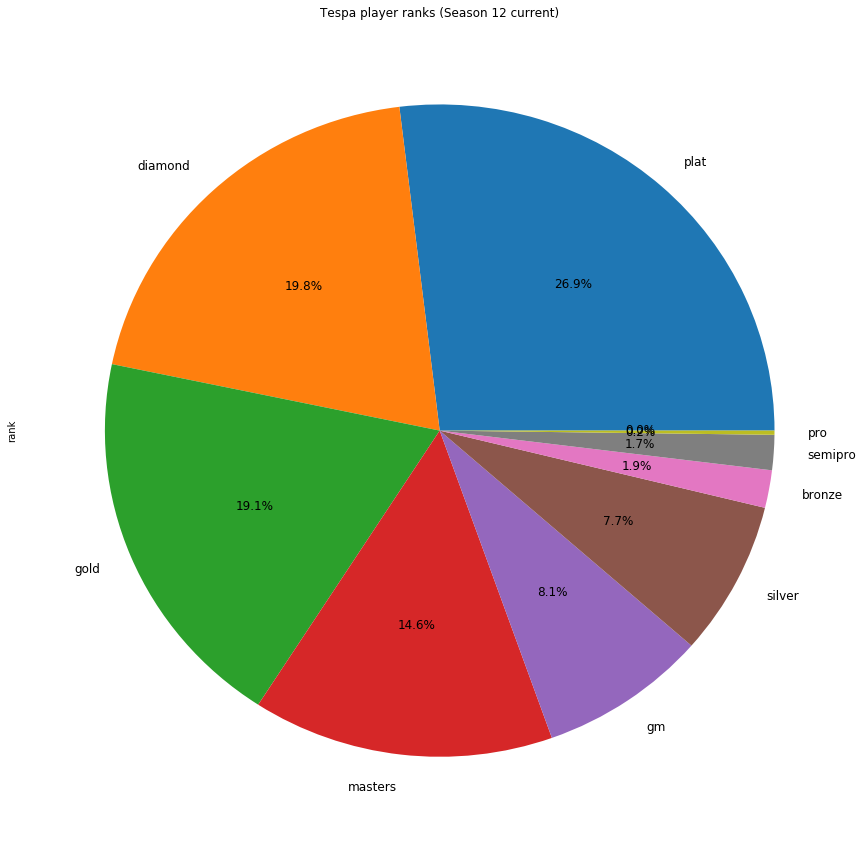

In [14]:
ax = pd.value_counts(df_btags['rank']).plot(kind='pie', title ="Tespa player ranks (Season 12 current)", autopct='%1.1f%%', figsize=(15, 15), legend=False, fontsize=12)
plt.show()

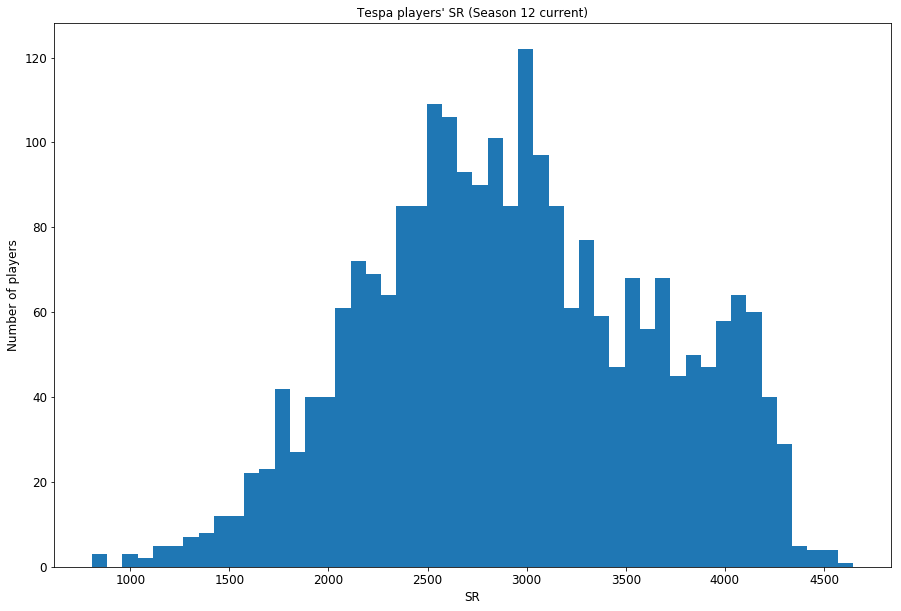

In [15]:
ax = df_btags['SR'].plot(kind='hist',title ="Tespa players' SR (Season 12 current)", bins=50,figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("SR", fontsize=12)
ax.set_ylabel("Number of players", fontsize=12)
plt.show()

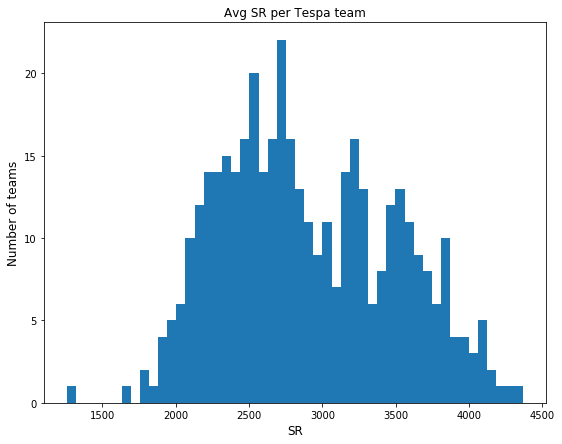

In [16]:
team_means = df_btags.groupby(['team_name'])['SR'].mean().sort_values()
ax = team_means.plot(kind='hist', bins=50, title='Avg SR per Tespa team') 
ax.set_xlabel("SR", fontsize=12)
ax.set_ylabel("Number of teams", fontsize=12)
plt.show()

In [17]:
# Tool to help my team scout by profiling a specific team
def get_current_team_info(team_name):
    global df_btags, team_means
    
    target = df_btags['team_name'] == team_name
    target = df_btags[target][['btag', 'SR', 'Comp_main', 'QP_main']]

    print (team_name, '9/30 Scrape:')
    print (target)
    print ("Average SR:", team_means[team_name])
    
    target[['SR', 'Comp_main', 'QP_main']] = target.apply(lambda row: pd.Series(get_stats(row['btag'].replace('#','-'))),axis=1)
    
    print ("Current stats:")
    print (target)
    print ("Average SR:", np.mean(target['SR']))
    
#get_current_team_info('Tartans')

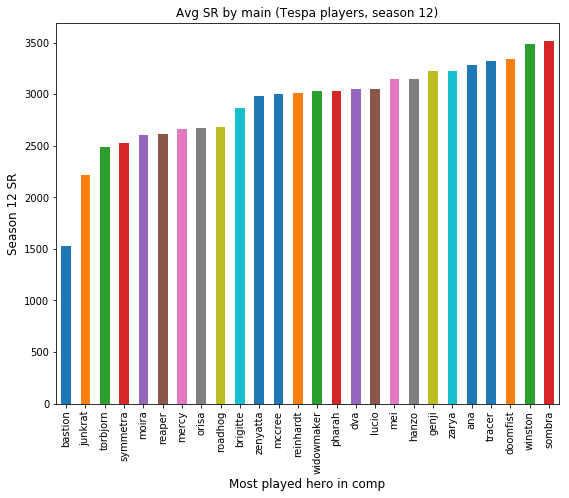

In [18]:
hero_means = df_btags.groupby(['Comp_main'])['SR'].mean().sort_values()
ax = hero_means.plot(kind='bar', title='Avg SR by main (Tespa players, season 12)') 
ax.set_xlabel("Most played hero in comp", fontsize=12)
ax.set_ylabel("Season 12 SR", fontsize=12)
plt.show()

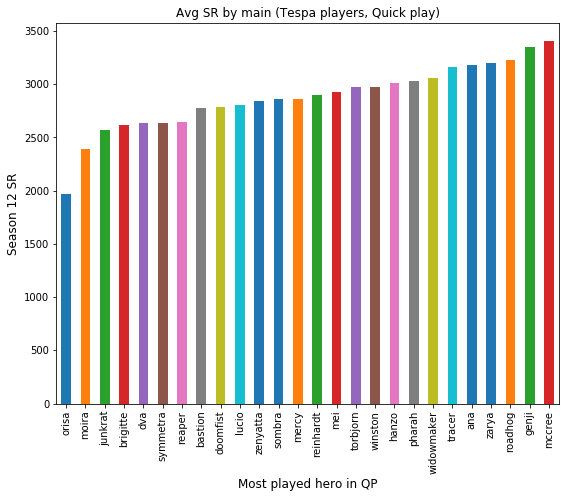

In [19]:
hero_means = df_btags.groupby(['QP_main'])['SR'].mean().sort_values()
ax = hero_means.plot(kind='bar', title='Avg SR by main (Tespa players, Quick play)') 
ax.set_xlabel("Most played hero in QP", fontsize=12)
ax.set_ylabel("Season 12 SR", fontsize=12)
plt.show()

In [20]:
# Match team_name format with df_btags
df_leaderboard['team_name'] = df_leaderboard['team_name'].apply(lambda x: x[x.find('] ') + 2:])
df_leaderboard

,rank,team_name,rating,timestamp
0,1,SafespaceSupervisors,1400,2018-10-03 12:52:48.201122
1,1,Utes Red,1400,2018-10-03 12:52:48.201322
2,3,Highnoonlanders,1398,2018-10-03 12:52:48.201487
3,4,FSU Crab Legs,1386,2018-10-03 12:52:48.201656
4,4,RIT Esports,1386,2018-10-03 12:52:48.201818
5,4,RU Rams,1386,2018-10-03 12:52:48.201980
6,4,Illini Esports,1386,2018-10-03 12:52:48.202140
7,4,Squagnar,1386,2018-10-03 12:52:48.202300
8,4,UCI Esports,1386,2018-10-03 12:52:48.202460
9,4,GCU Esports,1386,2018-10-03 12:52:48.202621


In [21]:
# Add average SR of team
df_leaderboard['team_avg_SR'] = df_leaderboard['team_name'].apply(lambda x: np.mean(df_btags.loc[df_btags['team_name'] == x]['SR']))
df_leaderboard['top6_avg_SR'] = df_leaderboard['team_name'].apply(lambda x: np.mean(df_btags.loc[df_btags['team_name'] == x].nlargest(6,'SR')['SR']))
df_leaderboard.sort_values('top6_avg_SR')

,rank,team_name,rating,timestamp,team_avg_SR,top6_avg_SR
142,143,Hard Rockers Team C,1048,2018-10-03 12:52:48.224397,1806.333333,1806.333333
159,158,WeWannaBeTheTeam,1000,2018-10-03 12:52:48.227060,1898.000000,1898.000000
155,149,Trine Rain,1014,2018-10-03 12:52:48.226460,1937.200000,1937.200000
145,144,Lees-McRae eSports,1028,2018-10-03 12:52:48.224851,1962.800000,1962.800000
156,149,Mason ¯\_(ツ)_/¯,1014,2018-10-03 12:52:48.226613,1964.000000,1964.000000
144,144,Villanova Wildcats,1028,2018-10-03 12:52:48.224700,2042.000000,2042.000000
87,87,LUCOW,1195,2018-10-03 12:52:48.215626,2078.666667,2078.666667
128,121,Mountaineers,1114,2018-10-03 12:52:48.222219,2091.000000,2091.000000
76,68,Butler Bulldogs,1200,2018-10-03 12:52:48.213948,2114.333333,2114.333333
119,103,LU Navy,1118,2018-10-03 12:52:48.220842,2073.571429,2150.833333


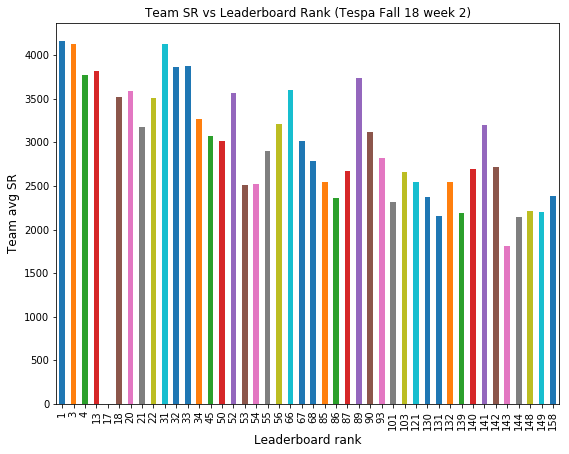

In [24]:
sr_rank = df_leaderboard.groupby(['rank'])['team_avg_SR'].mean()#.sort_values()
ax = sr_rank.plot(kind='bar', title='Team SR vs Leaderboard Rank (Tespa Fall 18 week 2)') 
ax.set_xlabel("Leaderboard rank", fontsize=12)
ax.set_ylabel("Team avg SR", fontsize=12)
plt.show()

**Note**: SR data collected on 9/30

In [31]:
df_leaderboard.loc[df_leaderboard['team_name'] == 'Tartans']

,rank,team_name,rating,timestamp,team_avg_SR,top6_avg_SR
140,141,Tartans,1090,2018-10-03 12:52:48.224091,3196.222222,3373.333333


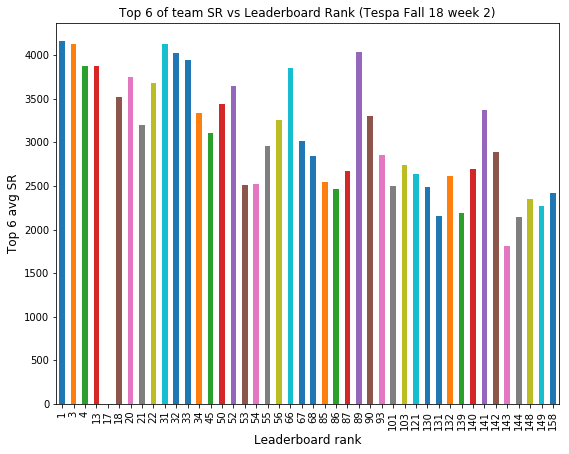

In [33]:
sr_rank = df_leaderboard.groupby(['rank'])['top6_avg_SR'].mean()#.sort_values()
ax = sr_rank.plot(kind='bar', title='Top 6 of team SR vs Leaderboard Rank (Tespa Fall 18 week 2)') 
ax.set_xlabel("Leaderboard rank", fontsize=12)
ax.set_ylabel("Top 6 avg SR", fontsize=12)
plt.show()

In [54]:
pd.options.mode.chained_assignment = None
for col in df_valid:
    df_valid[col] = df_valid[col].apply(lambda x: x.strip() if isinstance(x, str) else x)
    
df_valid

,team_name,team_school,team_link_url,team_rank,btag,member_count,team_rank1
0,Arizona Esports Blue,University of Arizona,https://compete.tespa.org/tournament/111/team/...,3,"[Revenos#1850, AgentSnow#1650, Bunnyoh#1970, I...",8,3
1,LU Red,Liberty University,https://compete.tespa.org/tournament/111/team/...,3,"[Blink2O2#1264, ebestdrew#1519, ebestrob#1193,...",8,3
2,Marist Red Foxes,Marist College,https://compete.tespa.org/tournament/111/team/...,4,"[nPPredator#1100, Faeryn#11265, Harmonix#11590...",8,4
3,NYU Ultraviolets,New York University,https://compete.tespa.org/tournament/111/team/...,4,"[Zephynel#1584, Mario#13710, tang#12918, Ronac...",8,4
4,NU Wildcats,Northwestern University,https://compete.tespa.org/tournament/111/team/...,5,"[Joe10112#1298, TheBaconHero#1759, Keeks#1597,...",8,5
5,Boomers,University of Oklahoma,https://compete.tespa.org/tournament/111/team/...,5,"[Thunderbird#11564, Amnael#11556, PatchesPop#1...",9,5
6,LSU Purple,Louisiana State University,https://compete.tespa.org/tournament/111/team/...,5,"[ADS#12301, Pulver#11652, LayK#1493, AAABatter...",9,5
7,Babbio Brawlers,Stevens Institute of Technology,https://compete.tespa.org/tournament/111/team/...,5,"[ElisMcGruber#1181, DoubleA#1795, Unk#11683, n...",8,5
8,Bulldogs,McPherson College,https://compete.tespa.org/tournament/111/team/...,5,"[TheRicker3#1508, LordSaxes#1114, Bob#14211, T...",8,5
9,bad lizards,Wilmington University,https://compete.tespa.org/tournament/111/team/...,5,"[R3KLE22K1LLR#1384, Weaselwez#1578, Schmidt#11...",8,5


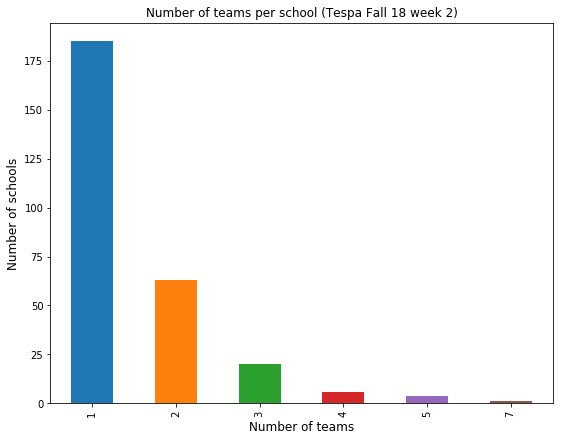

In [91]:
num_teams = df_valid.groupby(['team_school']).size()
ax = num_teams.value_counts().plot(kind='bar', title='Number of teams per school (Tespa Fall 18 week 2)') 
ax.set_xlabel("Number of teams", fontsize=12)
ax.set_ylabel("Number of schools", fontsize=12)
plt.show()



In [94]:
num_teams.sort_values()

team_school
Abilene Christian University                   1
Ryerson university                             1
Saint Ambrose University                       1
Saint Edward's University                      1
San Francisco State University                 1
San Jose State University                      1
Seton Hall University                          1
Shenandoah University                          1
Sheridan College                               1
Simon Fraser University                        1
Slippery Rock University                       1
Southeastern Louisiana University              1
Roger Williams University                      1
Southern Alberta Institute of Technology       1
Southern New Hampshire University              1
St. Clair College                              1
St. Lawrence College                           1
Stanford University                            1
State University of New York Canton            1
Stephens College                               1
Stonehil

In [85]:
type(num_teams)

pandas.core.series.Series

pandas.core.groupby.DataFrameGroupBy

In [80]:
s.values()

AttributeError: Cannot access attribute 'values' of 'DataFrameGroupBy' objects, try using the 'apply' method